# Aggregating manual annotations and correlations

We read the evaluation results from excel files that have the following columns:

Turn	
Speaker	
Cue	
Response	
Context

System ratings
* MLM response	
* System llh	
* MLM llh	
* USR DLcontext	
* USR DLfact	

Human ratings:
* Overall Human Rating	
* Interesting	
* Engaging	
* Specific	
* Relevant	
* Correct	
* Semantically Appropriate	
* Understandable	
* Fluent

In [1]:
# Needed to calculate the mean square error for regression scores
#! pip install sklearn

In [2]:
### Needed to read Ecel files: xlsx
# ! pip install openpyxl

In [2]:
from pathlib import Path
import glob
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt

#group = "g1-piek"
group = "g2-jaap"
#group = "g3-lea"
#group = "g4-tae"
annotation_path = "/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/"+group+"/scenario1"
#annotation_path = "."
basepath = Path(annotation_path)

In [3]:
def get_score_triples_from_turn(json_row:str, speaker_scores:{}, auto_score:str, hum_score:str):
    speaker = json_row['Speaker']
    turn = json_row['Turn']
    auto = json_row[auto_score]
    hum = json_row[hum_score]
    triple = (turn, auto, hum)
    if not speaker_scores.get(speaker):
        speaker_scores[speaker]=[]
    speaker_scores[speaker].append(triple)
    
def evaluate_regression_scores(basepath:Path, speaker_scores:{},auto_score:str, hum_score:str):
    turn_index =[]
    speaker_scores:{}
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            get_score_triples_from_turn(turn, speaker_scores, auto_score,hum_score)

def get_scores_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        if not turn_scores.get(turn):
            turn_scores[turn]=[]
        turn_scores[turn].append(score)

def get_score_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        turn_scores[turn]= score


def get_normalized_human_scores(basepath:Path, score_name:str):
    all_turn_scores = {}
    normalized_scores = {}
    averaged_score = []
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        if 'Turn' in df:
            print(path)
            js = df.to_json(orient = 'records')
            turn_scores={}
            for turn in json.loads(js):
                get_scores_for_turns(turn, turn_scores, score_name)
            for turn_id in turn_scores:
                if not all_turn_scores.get(turn_id):
                    all_turn_scores[turn_id]=[]
                all_turn_scores[turn_id].extend(turn_scores[turn_id])

    for turn_id in all_turn_scores:
        scores = all_turn_scores[turn_id]
        average = sum(scores)/len(scores)
        averaged_score.append(average)
        normalized_score = (average-1)/4
        normalized_scores[turn_id]=normalized_score
    averaged_score = sum(averaged_score)/len(averaged_score)
    #print(normalized_scores)
    #print(averaged_score)
    return normalized_scores, averaged_score

## Averaging the human annotations 

In [4]:
score_name = "Overall Human Rating"
normalized_scores_overall, average_overall = get_normalized_human_scores(basepath, score_name)

score_name = "Interesting"
normalized_scores_interesting, average_interesting = get_normalized_human_scores(basepath, score_name)

score_name = "Engaging"
normalized_scores_engaging, average_engaging = get_normalized_human_scores(basepath, score_name)

score_name = "Specific"
normalized_scores_specific, average_specific = get_normalized_human_scores(basepath, score_name)

score_name = "Relevant"
normalized_scores_relevant, average_relevant = get_normalized_human_scores(basepath, score_name)

score_name = "Correct"
normalized_scores_correct, average_correct = get_normalized_human_scores(basepath, score_name)

score_name = "Semantically Appropriate"
normalized_scores_semantic, average_semantic = get_normalized_human_scores(basepath, score_name)

score_name = "Understandable"
normalized_scores_understandable, average_understand = get_normalized_human_scores(basepath, score_name)

score_name = "Fluent"
normalized_scores_fluent, average_fluent = get_normalized_human_scores(basepath, score_name)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Ella scenario 1b.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Piotr scenario 1.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Ella scenario 1b.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Piotr scenario 1.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Ella scenario 1b.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Piotr scenario 1.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Ella scenario 1b.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Piotr scenario 1.csv
/Users/piek/Desktop/t-MA-Combots-2021/ev

In [5]:
print(average_overall)
print(average_interesting)
print(average_engaging)
print(average_specific)
print(average_relevant)
print(average_correct)
print(average_semantic)
print(average_understand)
print(average_fluent)

2.5714285714285716
1.5952380952380953
2.6904761904761907
2.3095238095238093
2.761904761904762
2.5476190476190474
2.4761904761904763
3.0476190476190474
2.4523809523809526


### Visualising the human ratings over turns

In [23]:
def extend__with_bar(width, normalized_scores:{}, score_name:str, plt, colors:[], used_colors):
    turns = list(normalized_scores.keys())
    ###We take all turns from the turn_index to create the x-axis
    x = np.arange(len(turns))
    y = []
    for key in normalized_scores:
        y.append(normalized_scores[key])
    c1 = choice(colors)   
    while c1 in used_colors:
        c1 = choice(colors)
    
    used_colors.append(c1)
    plt.barh(x+width, y,  color=c1, edgecolor="black", label=score_name, height=0.1)
    #plt.bar(x+width, y,  color=c1, width=barWidth, edgecolor="black", label=score_name)

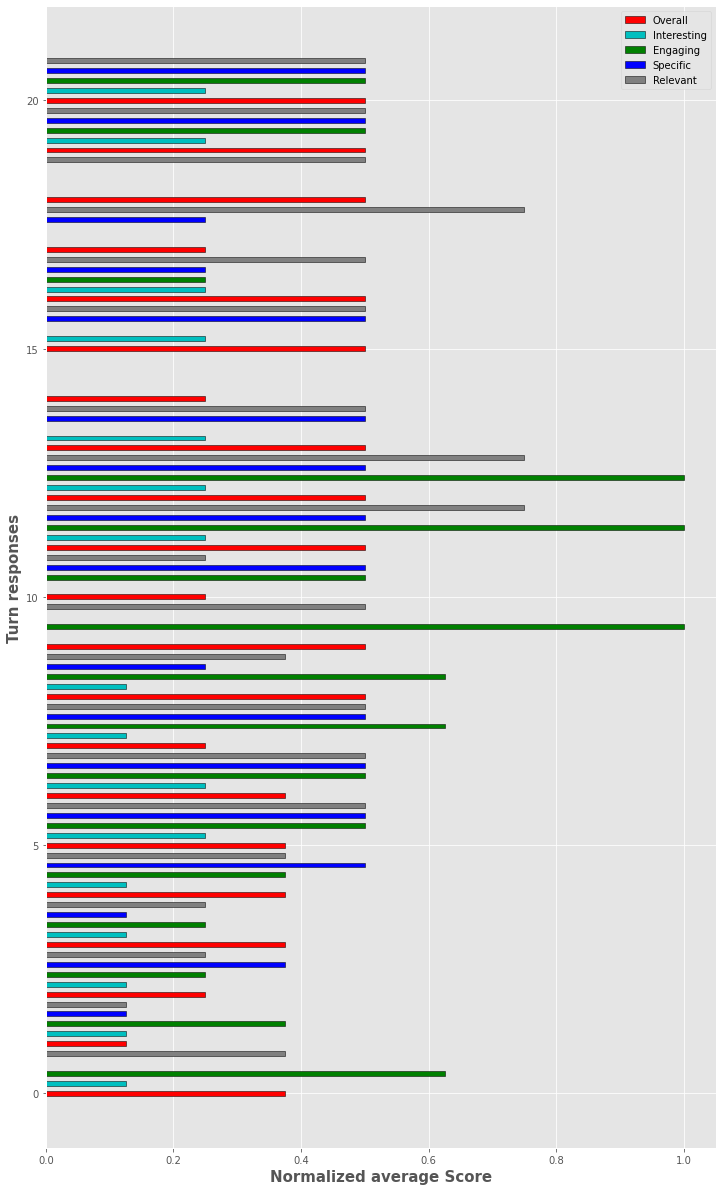

In [24]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

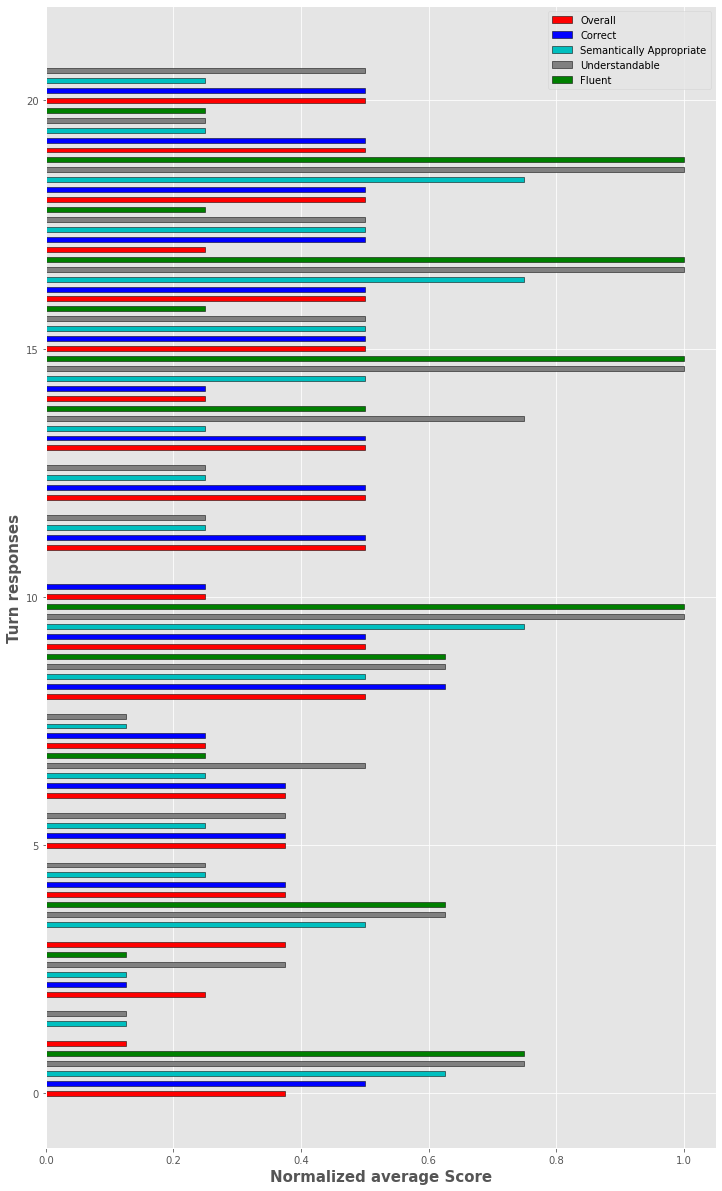

In [25]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

### Correlating the human annotations with overall rating

In [26]:
#https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_mean_error_area(scores_x, scores_y):
    x = []
    for key in scores_x:
        x.append(scores_x[key])
    y = []
    for key in scores_y:
        y.append(scores_y[key])
    #print(score_name_x, "&", score_name_y)
    mae = mean_absolute_error(x, y).round(2)
    mse = mean_squared_error(x, y).round(2)
    rmse = mean_squared_error(x, y, squared=False).round(2)
    #print(f"Mean Absolute Error:", mae)
    #print(f"Mean Squared Error:", mse)
    #print(f"Root Mean Squared Error:", rmse)
    return mae, mse, rmse

In [27]:
rows = []
score_name_x = "Overall Human Rating"

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_interesting)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_relevant)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_correct)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_semantic)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_understandable)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_fluent)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_scores = pd.DataFrame(rows)
df_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_scores.to_csv(file, index=False)

## Correlating automated score with the human ratings

### System likelihood of the agent answers

In [28]:
score_name_x = "System llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files


for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Ella scenario 1b.csv
21 {4: 0.365746311, 6: 0.352173857, 8: 0.332910785, 10: 0.559544234, 12: 0.251863712, 14: 0.246360421, 16: 0.24851859, 18: 0.421245757, 20: 0.401362117, 25: 0.580621159, 27: 0.338666272, 29: 0.434767036, 31: 0.793252739, 33: 0.405036385, 35: 0.081584394, 37: 0.374528967, 39: 0.62042765, 41: 0.388281996, 43: 0.60025584, 22: 0, 24: 0}
21 {4: 0.375, 6: 0.125, 8: 0.25, 10: 0.375, 12: 0.375, 14: 0.375, 16: 0.375, 18: 0.25, 20: 0.5, 25: 0.5, 27: 0.25, 29: 0.5, 31: 0.5, 33: 0.5, 35: 0.25, 37: 0.5, 39: 0.5, 41: 0.25, 43: 0.5, 22: 0.5, 24: 0.5}


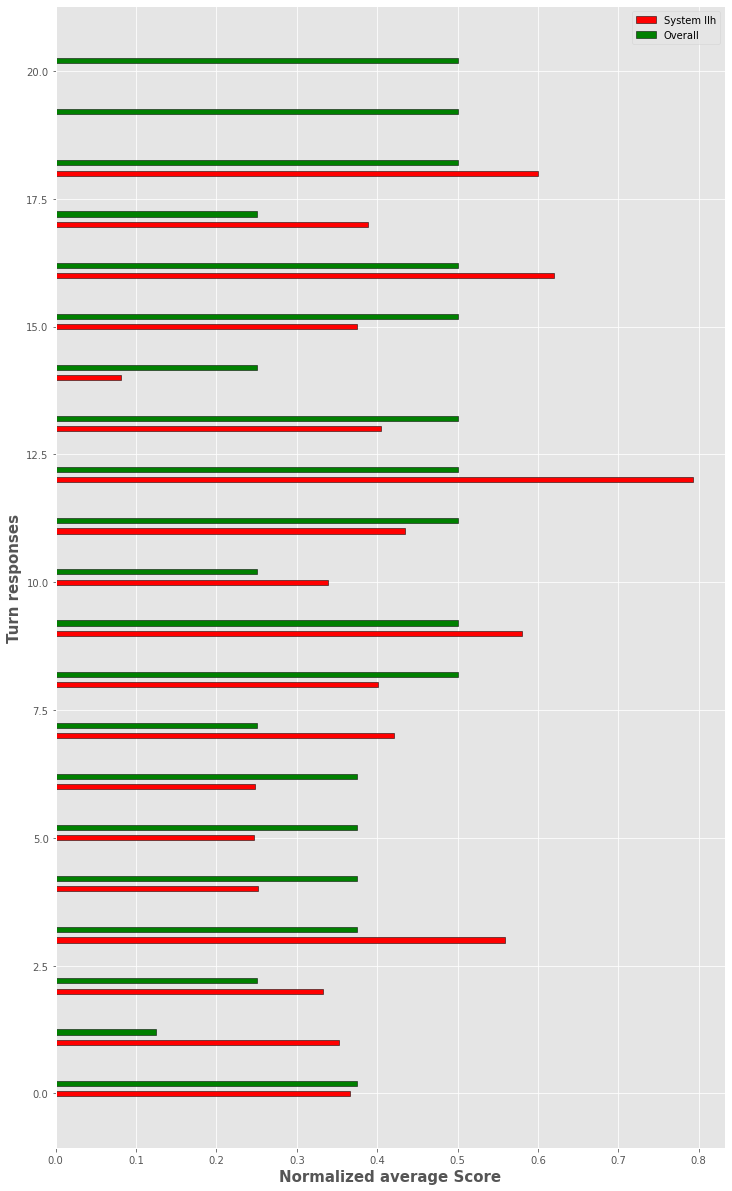

In [29]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()


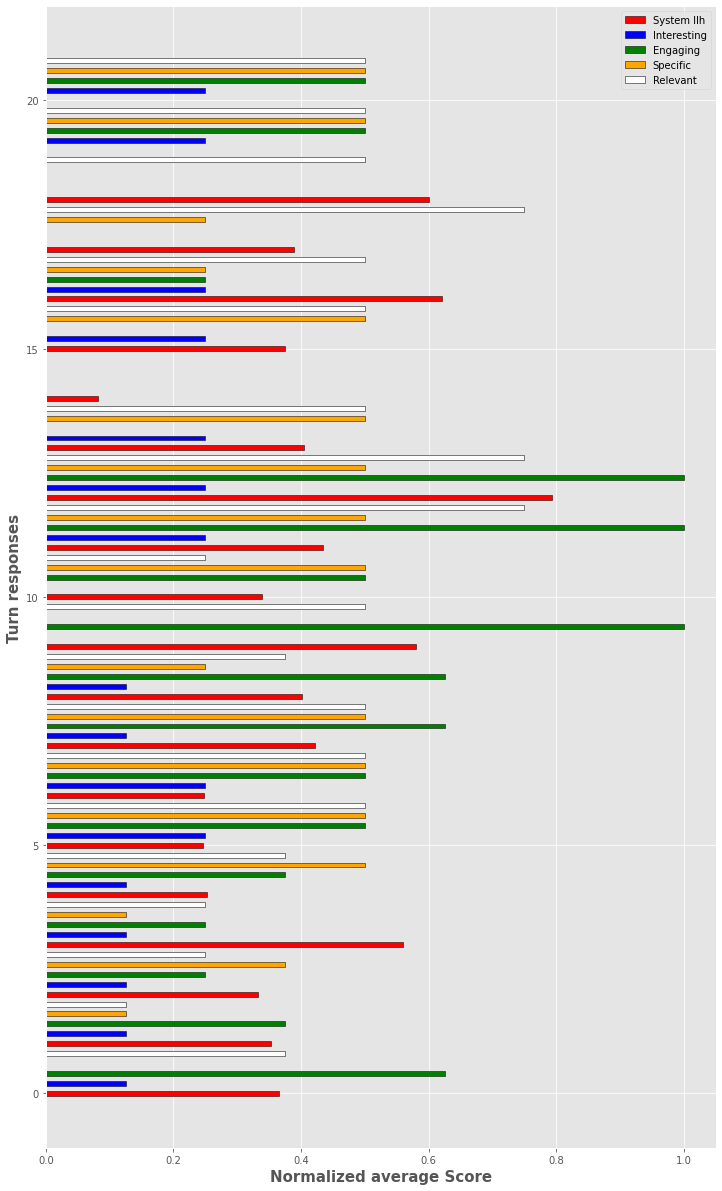

In [30]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)


score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)


plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()



In [31]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})



df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### MLM likelihood of the language model

In [32]:
score_name_x = "MLM llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

# Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)


/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Ella scenario 1b.csv
21 {4: 0.567305455, 6: 0.581127055, 8: 0.660395053, 10: 0.641875282, 12: 0.466307524, 14: 0.480422231, 16: 0.523669336, 18: 0.618641938, 20: 0.783523759, 25: 0.718405491, 27: 0.653402345, 29: 0.580307954, 31: 0.96879084, 33: 0.691771828, 35: 0.21878925, 37: 0.617429084, 39: 0.766519595, 41: 0.65224792, 43: 0.803267784, 22: 0, 24: 0}
21 {4: 0.375, 6: 0.125, 8: 0.25, 10: 0.375, 12: 0.375, 14: 0.375, 16: 0.375, 18: 0.25, 20: 0.5, 25: 0.5, 27: 0.25, 29: 0.5, 31: 0.5, 33: 0.5, 35: 0.25, 37: 0.5, 39: 0.5, 41: 0.25, 43: 0.5, 22: 0.5, 24: 0.5}


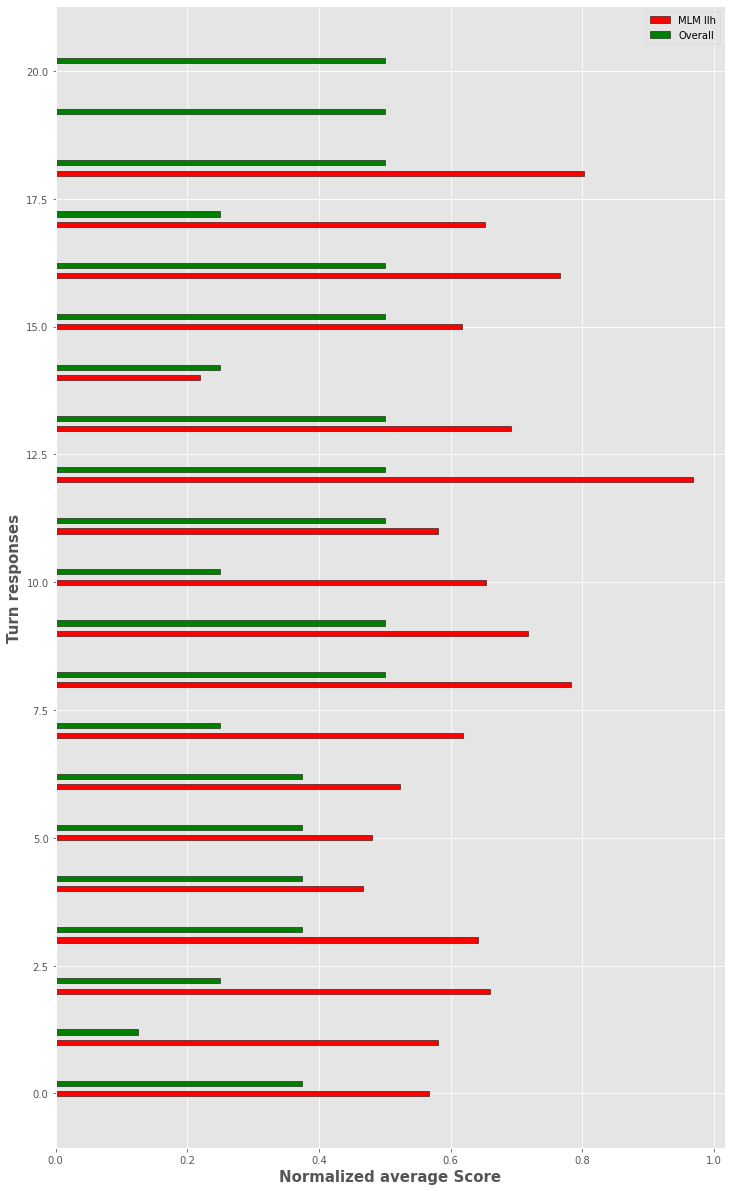

In [33]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

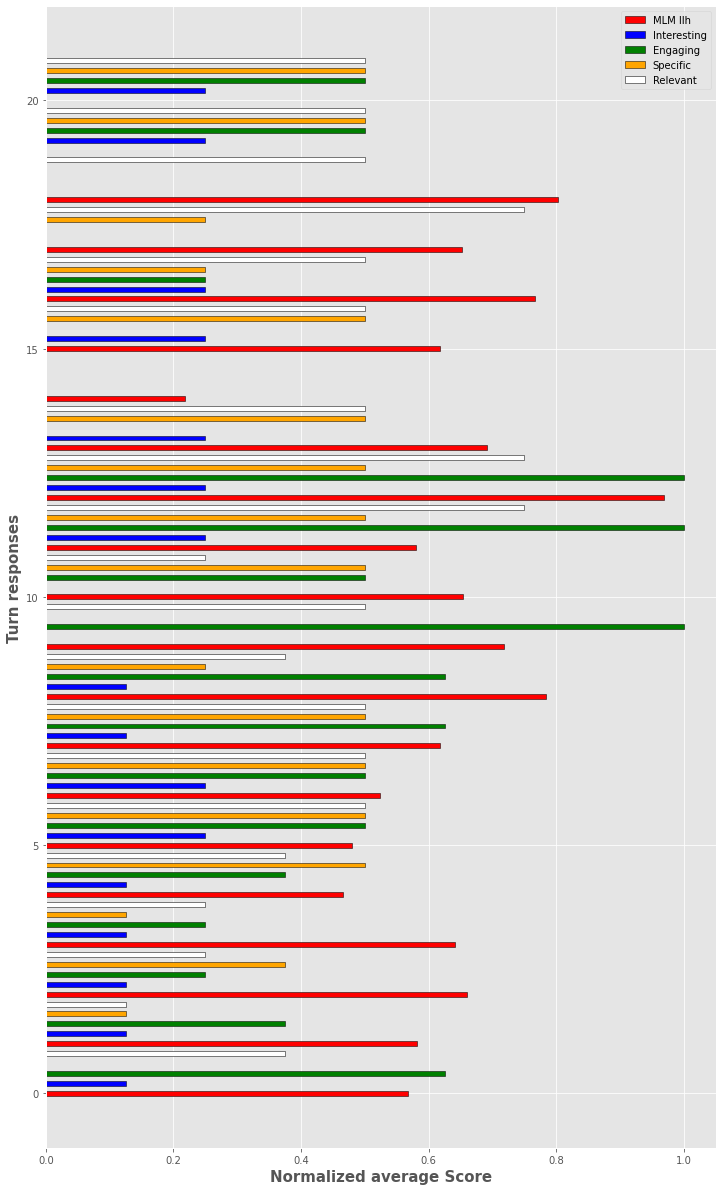

In [34]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

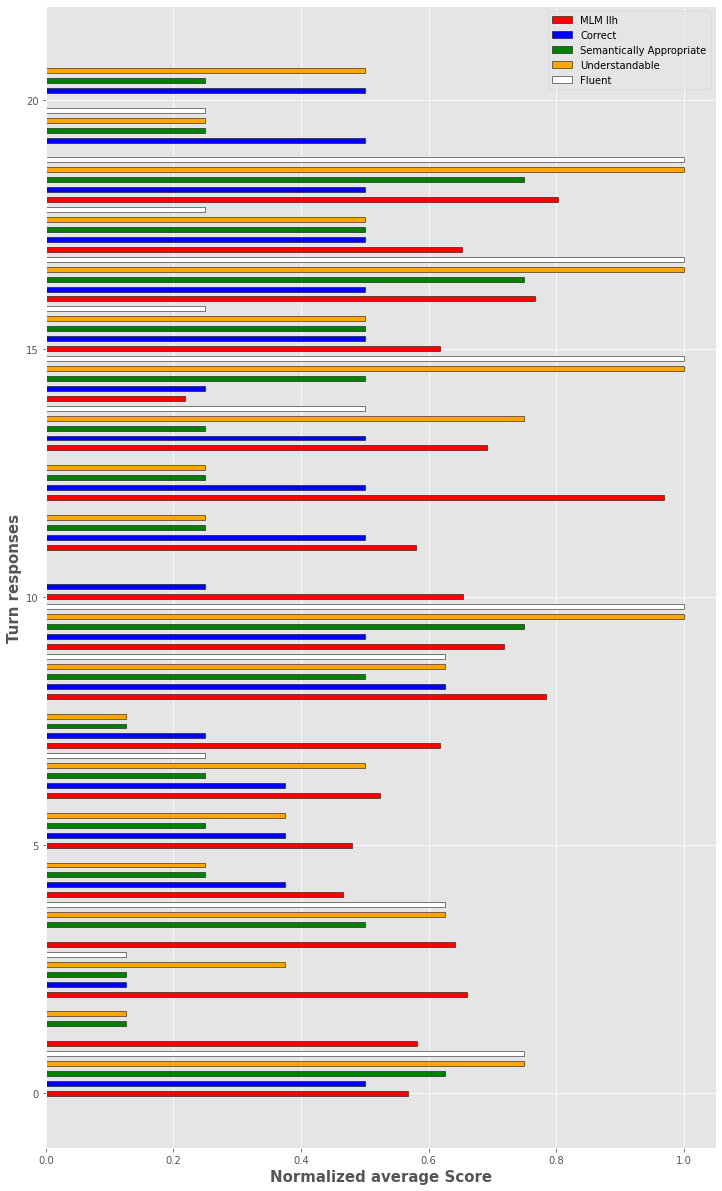

In [35]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [36]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLcontext

In [37]:
score_name_x = "USR DLcontext"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Ella scenario 1b.csv
21 {4: 0.9907801, 6: 0.9970981, 8: 0.9969802, 10: 0.010247797, 12: 0.997671, 14: 0.9966766, 16: 0.99719054, 18: 0.99809694, 20: 0.99802506, 25: 0.99780136, 27: 0.99705344, 29: 0.9981155, 31: 0.9981083, 33: 0.9954276, 35: 0.9974526, 37: 0.99788517, 39: 0.9977138, 41: 0.9604194, 43: 0.997016, 22: 0, 24: 0}
21 {4: 0.375, 6: 0.125, 8: 0.25, 10: 0.375, 12: 0.375, 14: 0.375, 16: 0.375, 18: 0.25, 20: 0.5, 25: 0.5, 27: 0.25, 29: 0.5, 31: 0.5, 33: 0.5, 35: 0.25, 37: 0.5, 39: 0.5, 41: 0.25, 43: 0.5, 22: 0.5, 24: 0.5}


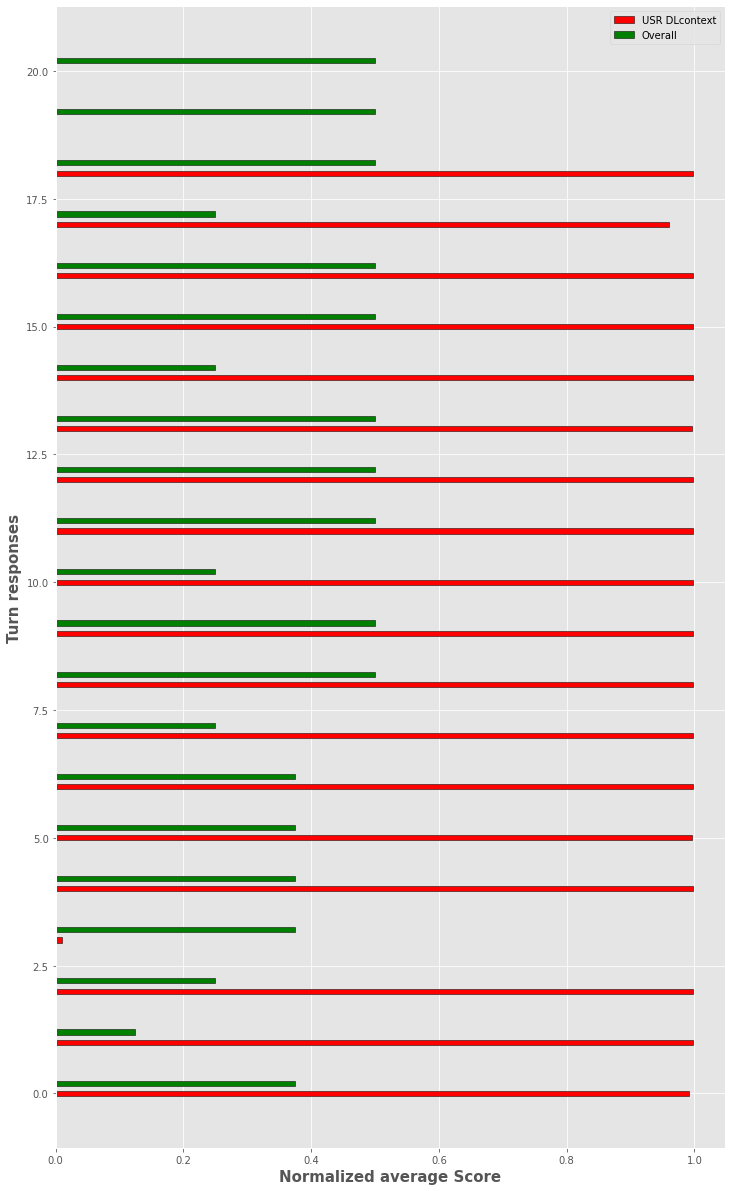

In [38]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

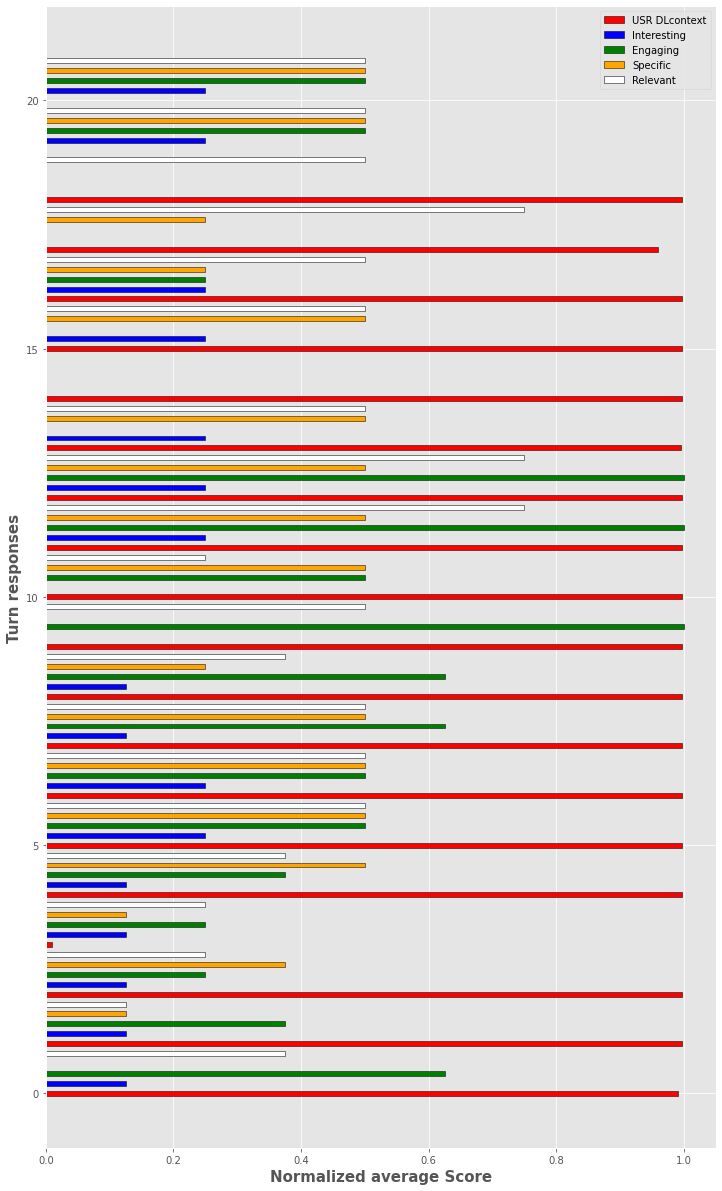

In [39]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

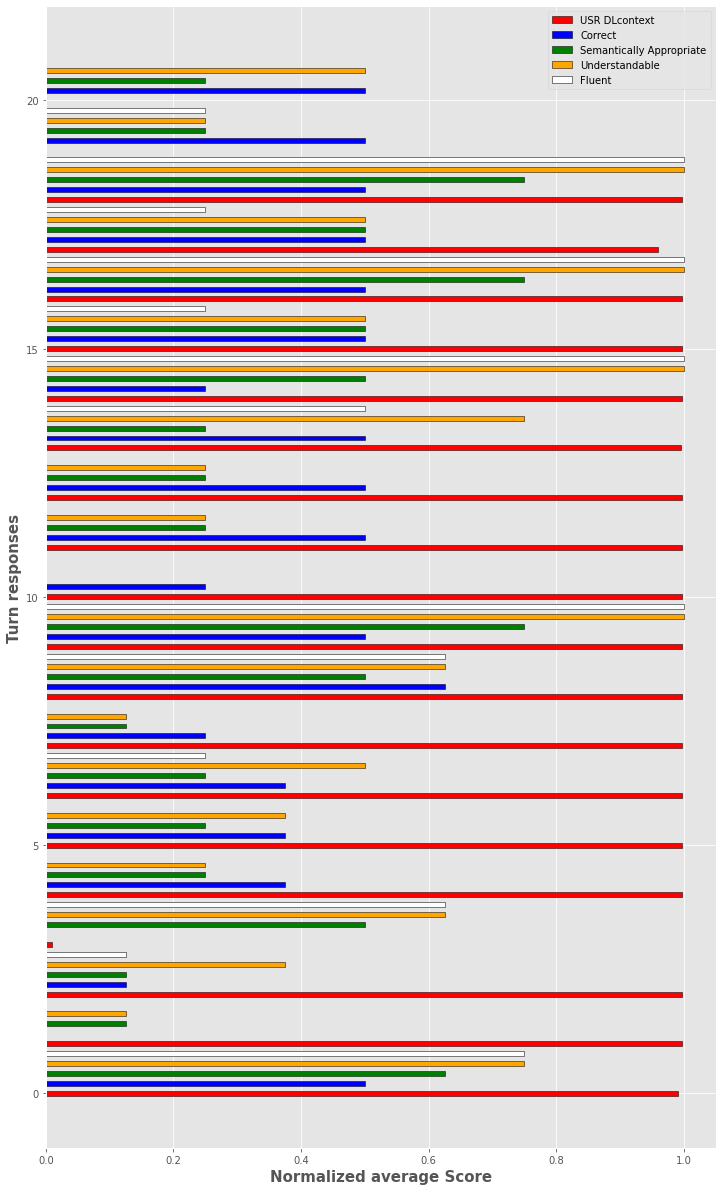

In [40]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [41]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLfact

In [42]:
score_name_x = "USR DLfact"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)



/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario1/annotation Ella scenario 1b.csv
21 {4: 0.9940913, 6: 0.99654484, 8: 0.9948791, 10: 0.9914957, 12: 0.9955981, 14: 0.99562186, 16: 0.9941027, 18: 0.99579597, 20: 0.9836624, 25: 0.9970257, 27: 0.9961896, 29: 0.3997416, 31: 0.9964049, 33: 0.99713194, 35: 0.9964376, 37: 0.99682117, 39: 0.9970524, 41: 0.9971472, 43: 0.99707705, 22: 0, 24: 0}
21 {4: 0.375, 6: 0.125, 8: 0.25, 10: 0.375, 12: 0.375, 14: 0.375, 16: 0.375, 18: 0.25, 20: 0.5, 25: 0.5, 27: 0.25, 29: 0.5, 31: 0.5, 33: 0.5, 35: 0.25, 37: 0.5, 39: 0.5, 41: 0.25, 43: 0.5, 22: 0.5, 24: 0.5}


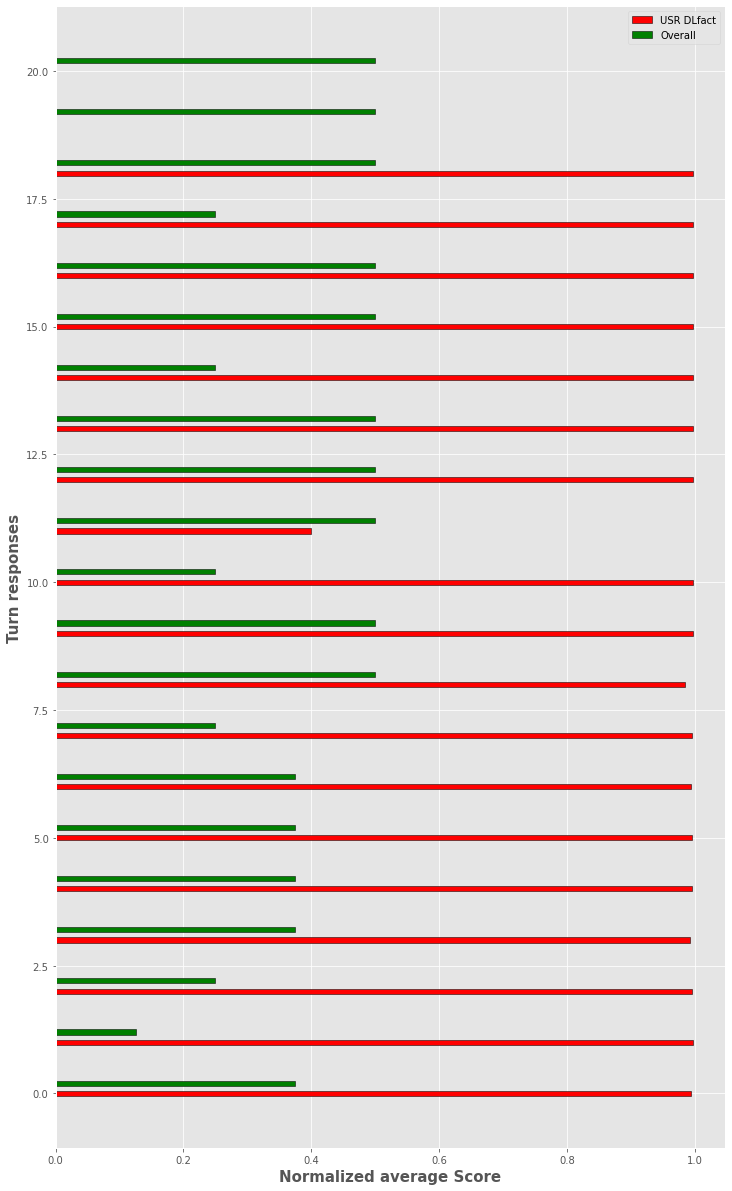

In [43]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

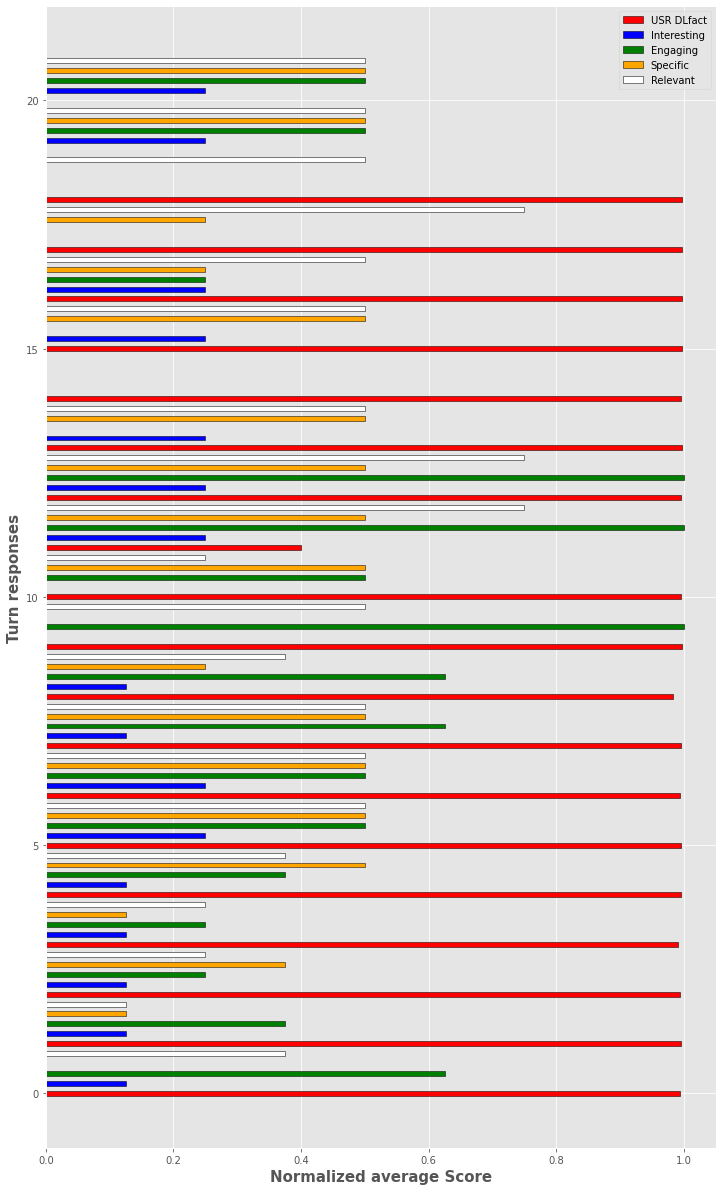

In [44]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

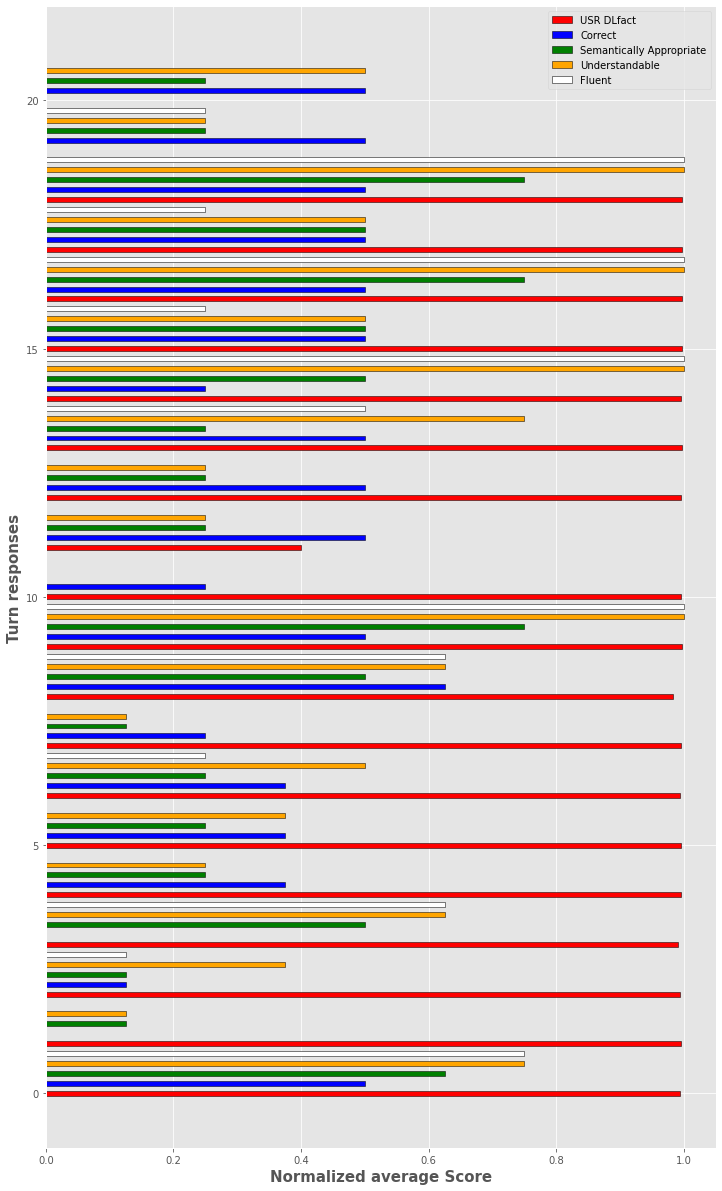

In [45]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [46]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

## End of notebook